In [1]:
# Cell 1: Imports and Data Load

import pandas as pd

# Load the first 25 000 rows
df = pd.read_csv('../files/first_25000_rows.csv')
df.head()


,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2024-10-21T11:54:29.221230963Z,2024-10-21T11:54:29.221064336Z,10,2,38,C,B,1,233.62,2,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
1,2024-10-21T11:54:29.223936626Z,2024-10-21T11:54:29.223769812Z,10,2,38,A,B,0,233.67,2,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
2,2024-10-21T11:54:29.225196809Z,2024-10-21T11:54:29.225030400Z,10,2,38,A,B,0,233.67,3,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
3,2024-10-21T11:54:29.712600612Z,2024-10-21T11:54:29.712434212Z,10,2,38,A,B,2,233.52,200,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
4,2024-10-21T11:54:29.764839221Z,2024-10-21T11:54:29.764673165Z,10,2,38,C,B,2,233.52,200,...,155,1,7,233.25,234.13,55,400,2,1,AAPL


In [2]:
# Cell 2: Parse and sort by event timestamp

# Convert event timestamp to pandas datetime
df['ts_event'] = pd.to_datetime(df['ts_event'])

# Sort in chronological order
df = df.sort_values('ts_event').reset_index(drop=True)
df[['ts_event']].head()


,ts_event
0,2024-10-21 11:54:29.221064336+00:00
1,2024-10-21 11:54:29.223769812+00:00
2,2024-10-21 11:54:29.225030400+00:00
3,2024-10-21 11:54:29.712434212+00:00
4,2024-10-21 11:54:29.764673165+00:00


In [3]:
# Cell 3: Prepare “previous” best‐level quotes

# Shift best bid/ask price & size by one event
df['prev_bid_price'] = df['bid_px_00'].shift(1)
df['prev_bid_size']  = df['bid_sz_00'].shift(1)
df['prev_ask_price'] = df['ask_px_00'].shift(1)
df['prev_ask_size']  = df['ask_sz_00'].shift(1)

# Inspect
df[['bid_px_00','prev_bid_price','bid_sz_00','prev_bid_size',
    'ask_px_00','prev_ask_price','ask_sz_00','prev_ask_size']].head()


,bid_px_00,prev_bid_price,bid_sz_00,prev_bid_size,ask_px_00,prev_ask_price,ask_sz_00,prev_ask_size
0,233.67,NaN,139,NaN,233.74,NaN,200,NaN
1,233.67,233.67,141,139.0,233.74,233.74,200,200.0
2,233.67,233.67,144,141.0,233.74,233.74,200,200.0
3,233.67,233.67,144,144.0,233.74,233.74,200,200.0
4,233.67,233.67,144,144.0,233.74,233.74,200,200.0


In [4]:
# Cell 4: Define the flow‐computation function

def compute_flow(current_price, prev_price, current_size, prev_size):
    """
    If price moves up: count full current_size (+).
    If price moves down: count full current_size (−).
    If unchanged: net change in size.
    """
    if current_price > prev_price:
        return  current_size
    elif current_price < prev_price:
        return -current_size
    else:
        return current_size - prev_size


In [5]:
# Cell 5: Compute bid & ask flows, then per‐event OFI

# Best‐level bid flow
df['bid_flow_0'] = df.apply(
    lambda r: compute_flow(r['bid_px_00'], r['prev_bid_price'],
                           r['bid_sz_00'], r['prev_bid_size']), axis=1)

# Best‐level ask flow (note price arguments flipped)
df['ask_flow_0'] = df.apply(
    lambda r: compute_flow(r['prev_ask_price'], r['ask_px_00'],
                           r['prev_ask_size'], r['ask_sz_00']), axis=1)

# Event‐level best‐level OFI
df['ofi_best_event'] = df['bid_flow_0'] - df['ask_flow_0']

df[['bid_flow_0','ask_flow_0','ofi_best_event']].head()


,bid_flow_0,ask_flow_0,ofi_best_event
0,NaN,NaN,NaN
1,2.0,0.0,2.0
2,3.0,0.0,3.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [7]:
# Cell 6: Aggregate to one OFI value per minute

# Floor to minute
df['minute'] = df['ts_event'].dt.floor('min')

# Sum OFI within each minute
ofi_per_minute = (
    df.groupby('minute')['ofi_best_event']
      .sum()
      .reset_index()
      .rename(columns={'ofi_best_event':'ofi_best_level'})
)

ofi_per_minute.head()


,minute,ofi_best_level
0,2024-10-21 11:54:00+00:00,-133.0
1,2024-10-21 11:55:00+00:00,-820.0
2,2024-10-21 11:56:00+00:00,-268.0
3,2024-10-21 11:57:00+00:00,103.0
4,2024-10-21 11:58:00+00:00,982.0


<Axes: title={'center': 'Best‐Level OFI per Minute'}, xlabel='minute'>

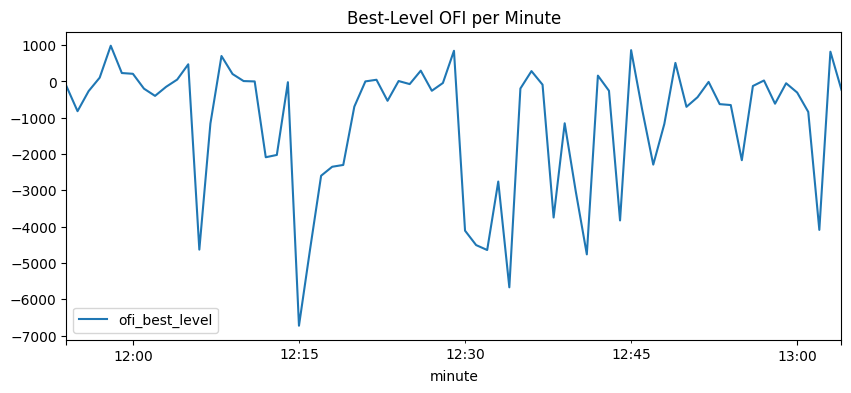

In [8]:
# Cell 7: (Optional) Visualize or export

# Example: save to CSV
ofi_per_minute.to_csv('ofi_best_level_per_minute.csv', index=False)

# Or display inline:
ofi_per_minute.plot(x='minute', y='ofi_best_level', figsize=(10,4), title='Best‐Level OFI per Minute')
